Citation

Tschandl, Philipp, 2018, "The HAM10000 dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions", https://doi.org/10.7910/DVN/DBW86T, Harvard Dataverse, V4, UNF:6:KCZFcBLiFE5ObWcTc2ZBOA== [fileUNF]

In [1]:
import pandas as pd
import numpy as np

import random

import pickle

import tensorflow as tf

import matplotlib.pyplot as plt

import os.path

import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

from PIL import Image
from PIL import ImageOps

from keras.utils import to_categorical

from sklearn.utils import resample

from sklearn.preprocessing import OneHotEncoder

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix

from sklearn.metrics import ConfusionMatrixDisplay

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

from keras.optimizers import Adam

from keras.models import load_model

# 1 Data

### 1.1 Cleaning and exploration

In [3]:
data = pd.read_csv('fbp_data0.csv')

In [4]:
data

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
...,...,...,...,...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec,histo,40.0,male,abdomen
10011,HAM_0002867,ISIC_0033550,akiec,histo,40.0,male,abdomen
10012,HAM_0002867,ISIC_0033536,akiec,histo,40.0,male,abdomen
10013,HAM_0000239,ISIC_0032854,akiec,histo,80.0,male,face


In [5]:
pd.crosstab(data.dx, data.localization)

localization,abdomen,acral,back,chest,ear,face,foot,genital,hand,lower extremity,neck,scalp,trunk,unknown,upper extremity
dx,,,,,,,,,,,,,,,
akiec,5,0,29,12,3,113,0,0,13,65,10,14,1,0,62
bcc,18,0,186,47,0,101,4,0,2,58,14,19,11,5,49
bkl,42,0,202,74,6,319,1,2,14,174,31,34,73,23,104
df,4,0,2,0,0,0,2,1,0,82,0,0,0,0,24
mel,66,0,324,68,17,104,28,0,1,192,29,14,47,10,213
nv,860,7,1427,200,30,100,284,45,55,1479,81,45,1241,196,655
vasc,27,0,22,6,0,8,0,0,5,27,3,2,31,0,11


> I will drop rows that have too few instances, as they can introduce noise to the model.

In [6]:
data = data[data['dx'] != 'df']

In [7]:
data = data[data['dx'] != 'vasc']

In [8]:
data = data[data['localization'] != 'acral']

In [9]:
data = data[data['localization'] != 'ear']

In [10]:
data = data[data['localization'] != 'foot']

In [11]:
data = data[data['localization'] != 'genital']

In [12]:
data = data[data['localization'] != 'hand']

In [13]:
data = data[data['localization'] != 'unknown']

### 1.2 Sets of Lesion

> The set of pictures is computationally heavy and expensive. Therefore, I am planning to divide it into three sets. Two of these sets will serve as training data for two different models, while the third one will be used as a test set, to be evaluated with both models.
>
> I want each of the three sets to have the same proportion of lesions. Therefore, I'll start by creating five sets for each type of lesion.

In [14]:
data['dx'].value_counts()

nv       6088
mel      1057
bkl      1053
bcc       503
akiec     311
Name: dx, dtype: int64

In [15]:
nv = data[data['dx']=='nv'].reset_index(drop=True)

In [135]:
akiec



,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0002644,ISIC_0029417,1,histo,80.0,female,neck
1,HAM_0006002,ISIC_0029915,1,histo,50.0,female,face
2,HAM_0000549,ISIC_0029360,1,histo,70.0,male,upper extremity
3,HAM_0000549,ISIC_0026152,1,histo,70.0,male,upper extremity
4,HAM_0000673,ISIC_0029659,1,histo,70.0,female,face
...,...,...,...,...,...,...,...
306,HAM_0005705,ISIC_0031430,1,histo,75.0,female,lower extremity
307,HAM_0002867,ISIC_0033084,1,histo,40.0,male,abdomen
308,HAM_0002867,ISIC_0033550,1,histo,40.0,male,abdomen
309,HAM_0002867,ISIC_0033536,1,histo,40.0,male,abdomen


In [16]:
mel = data[data['dx']=='mel'].reset_index(drop=True)  

In [17]:
bkl = data[data['dx']=='bkl'].reset_index(drop=True)     

In [18]:
bcc = data[data['dx']=='bcc'].reset_index(drop=True)     

In [19]:
akiec = data[data['dx']=='akiec'].reset_index(drop=True)     

### <font color='orange'>Assumption:</font> 
I consider akiec as a malignant lesion because it is popularly known as a precancerous lesion.

# 2 Images Processing

> The images processed by the models need to be distinct, and the test images must be identical. However, one model will utilize grayscale pictures while the other will use RGB pictures. Therefore, I need to prepare the same test set in these two different formats.
>
> You will notice that some cells are commented, while others are not. To improve efficiency, I am only keeping the lightweight cells. For the RGB images, I've saved the array so I can simply open it. Additionally, we no longer need the training images as the models have been trained, fit, and saved. We can upload them later on.

### 2.1 Train Grayscale

> The array for this set should be in the format (number of pictures, height, width, and number of channels = 1 for grayscale).
>
> First, I'll open them using the 'open' function from the PIL library. Then, I'll convert them to grayscale format and into an array. 
>
> Afterwards, I'll select which indexes will be included in this set and append them to the main training array that will be used for the model.
>
> In order to have balanced sets, I´ll chose 69 features for the 3 benign classes, and 103 for the malignant ones.

In [20]:
# image_nv = Image.open('fbp_pictures_1/ISIC_0024698.jpg')
# image_nv = ImageOps.grayscale(image_nv)
# image_nv = np.array(image_nv)

# image_mel = Image.open('fbp_pictures_1/ISIC_0025964.jpg')
# image_mel = ImageOps.grayscale(image_mel)
# image_mel = np.array(image_mel)

# image_bkl = Image.open('fbp_pictures_1/ISIC_0027419.jpg')
# image_bkl = ImageOps.grayscale(image_bkl)
# image_bkl = np.array(image_bkl)

# image_bcc = Image.open('fbp_pictures_1/ISIC_0028155.jpg')
# image_bcc = ImageOps.grayscale(image_bcc)
# image_bcc = np.array(image_bcc)

# image_akiec = Image.open('fbp_pictures_1/ISIC_0029417.jpg')
# image_akiec = ImageOps.grayscale(image_akiec)
# image_akiec = np.array(image_akiec)

In [21]:
# image_nv_col = nv.loc[1:102, ['image_id']]
# image_mel_col = mel.loc[1:68, ['image_id']]
# image_bkl_col = bkl.loc[1:102, ['image_id']]
# image_bcc_col = bcc.loc[1:68, ['image_id']]
# image_akiec_col = akiec.loc[1:68, ['image_id']]

In [22]:
# images_nv = image_nv.reshape(1, 450, 600, 1)
# images_mel = image_mel.reshape(1, 450, 600, 1)
# images_bkl = image_bkl.reshape(1, 450, 600, 1)
# images_bcc = image_bcc.reshape(1, 450, 600, 1)
# images_akiec = image_akiec.reshape(1, 450, 600, 1)

# for i in image_nv_col['image_id']:
#     image_nv = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_nv = ImageOps.grayscale(image_nv)
#     image_nv = np.array(image_nv)
#     image_nv = image_nv.reshape(1, 450, 600, 1)
#     images_nv = np.vstack([images_nv, image_nv])

# for i in image_mel_col['image_id']:
#     image_mel = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_mel = ImageOps.grayscale(image_mel)
#     image_mel = np.array(image_mel)
#     image_mel = image_mel.reshape(1, 450, 600, 1)
#     images_mel = np.vstack([images_mel, image_mel])
    
# for i in image_bkl_col['image_id']:
#     image_bkl = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bkl = ImageOps.grayscale(image_bkl)
#     image_bkl = np.array(image_bkl)
#     image_bkl = image_bkl.reshape(1, 450, 600, 1)
#     images_bkl = np.vstack([images_bkl, image_bkl])

# for i in image_bcc_col['image_id']:
#     image_bcc = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bcc = ImageOps.grayscale(image_bcc)
#     image_bcc = np.array(image_bcc)
#     image_bcc = image_bcc.reshape(1, 450, 600, 1)
#     images_bcc = np.vstack([images_bcc, image_bcc])
    
# for i in image_akiec_col['image_id']:
#     image_akiec = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_akiec = ImageOps.grayscale(image_akiec)
#     image_akiec = np.array(image_akiec)
#     image_akiec = image_akiec.reshape(1, 450, 600, 1)
#     images_akiec = np.vstack([images_akiec, image_akiec])
    
# images_gray_train = np.vstack([images_nv, images_mel, images_bkl, images_bcc, images_akiec])

In [23]:
# images_gray_train.shape

### 2.2 Test Grayscale

> Same as previous, but with the next set of pictures.

In [24]:
akiec.loc[69, ['image_id']]

image_id    ISIC_0031940
Name: 69, dtype: object

In [43]:
image_nv = Image.open('fbp_pictures_1/ISIC_0027974.jpg')
image_nv = ImageOps.grayscale(image_nv)
image_nv = np.array(image_nv)

image_mel = Image.open('fbp_pictures_1/ISIC_0026909.jpg')
image_mel = ImageOps.grayscale(image_mel)
image_mel = np.array(image_mel)

image_bkl = Image.open('fbp_pictures_1/ISIC_0024623.jpg')
image_bkl = ImageOps.grayscale(image_bkl)
image_bkl = np.array(image_bkl)

image_bcc = Image.open('fbp_pictures_1/ISIC_0027117.jpg')
image_bcc = ImageOps.grayscale(image_bcc)
image_bcc = np.array(image_bcc)

image_akiec = Image.open('fbp_pictures_1/ISIC_0031940.jpg')
image_akiec = ImageOps.grayscale(image_akiec)
image_akiec = np.array(image_akiec)

In [44]:
image_nv_col = nv.loc[104:205, ['image_id']]
image_mel_col = mel.loc[70:137, ['image_id']]
image_bkl_col = bkl.loc[104:205, ['image_id']]
image_bcc_col = bcc.loc[70:137, ['image_id']]
image_akiec_col = akiec.loc[70:137, ['image_id']]


images_nv = image_nv.reshape(1, 450, 600, 1)
images_mel = image_mel.reshape(1, 450, 600, 1)
images_bkl = image_bkl.reshape(1, 450, 600, 1)
images_bcc = image_bcc.reshape(1, 450, 600, 1)
images_akiec = image_akiec.reshape(1, 450, 600, 1)

for i in image_nv_col['image_id']:
    image_nv = Image.open('fbp_pictures_1/' + i + '.jpg')
    image_nv = ImageOps.grayscale(image_nv)
    image_nv = np.array(image_nv)
    image_nv = image_nv.reshape(1, 450, 600, 1)
    images_nv = np.vstack([images_nv, image_nv])

for i in image_mel_col['image_id']:
    image_mel = Image.open('fbp_pictures_1/' + i + '.jpg')
    image_mel = ImageOps.grayscale(image_mel)
    image_mel = np.array(image_mel)
    image_mel = image_mel.reshape(1, 450, 600, 1)
    images_mel = np.vstack([images_mel, image_mel])
    
for i in image_bkl_col['image_id']:
    image_bkl = Image.open('fbp_pictures_1/' + i + '.jpg')
    image_bkl = ImageOps.grayscale(image_bkl)
    image_bkl = np.array(image_bkl)
    image_bkl = image_bkl.reshape(1, 450, 600, 1)
    images_bkl = np.vstack([images_bkl, image_bkl])

for i in image_bcc_col['image_id']:
    image_bcc = Image.open('fbp_pictures_1/' + i + '.jpg')
    image_bcc = ImageOps.grayscale(image_bcc)
    image_bcc = np.array(image_bcc)
    image_bcc = image_bcc.reshape(1, 450, 600, 1)
    images_bcc = np.vstack([images_bcc, image_bcc])
    
for i in image_akiec_col['image_id']:
    image_akiec = Image.open('fbp_pictures_1/' + i + '.jpg')
    image_akiec = ImageOps.grayscale(image_akiec)
    image_akiec = np.array(image_akiec)
    image_akiec = image_akiec.reshape(1, 450, 600, 1)
    images_akiec = np.vstack([images_akiec, image_akiec])
    
images_gray_test = np.vstack([images_nv, images_mel, images_bkl, images_bcc, images_akiec])


images_gray_test.shape

(413, 450, 600, 1)

### 2.3 Train RGB

> In this case, the number of channels will be 3, and the images don't need to undergo the grayscale transformation

In [45]:
# akiec.loc[206, ['image_id']]

In [46]:
# image_nv = Image.open('fbp_pictures_1/ISIC_0025692.jpg')
# image_nv = np.array(image_nv)

# image_mel = Image.open('fbp_pictures_1/ISIC_0033899.jpg')
# image_mel = np.array(image_mel)

# image_bkl = Image.open('fbp_pictures_1/ISIC_0033899.jpg')
# image_bkl = np.array(image_bkl)

# image_bcc = Image.open('fbp_pictures_1/ISIC_0027090.jpg')
# image_bcc = np.array(image_bcc)

# image_akiec = Image.open('fbp_pictures_1/ISIC_0029638.jpg')
# image_akiec = np.array(image_akiec)

In [47]:
# image_nv_col = nv.loc[207:308, ['image_id']]
# image_mel_col = mel.loc[139:206, ['image_id']]
# image_bkl_col = bkl.loc[207:308, ['image_id']]
# image_bcc_col = bcc.loc[139:206, ['image_id']]
# image_akiec_col = akiec.loc[139:206, ['image_id']]


# images_nv = image_nv.reshape(1, 450, 600, 3)
# images_mel = image_mel.reshape(1, 450, 600, 3)
# images_bkl = image_bkl.reshape(1, 450, 600, 3)
# images_bcc = image_bcc.reshape(1, 450, 600, 3)
# images_akiec = image_akiec.reshape(1, 450, 600, 3)

# for i in image_nv_col['image_id']:
#     image_nv = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_nv = np.array(image_nv)
#     image_nv = image_nv.reshape(1, 450, 600, 3)
#     images_nv = np.vstack([images_nv, image_nv])

# for i in image_mel_col['image_id']:
#     image_mel = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_mel = np.array(image_mel)
#     image_mel = image_mel.reshape(1, 450, 600, 3)
#     images_mel = np.vstack([images_mel, image_mel])
    
# for i in image_bkl_col['image_id']:
#     image_bkl = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bkl = np.array(image_bkl)
#     image_bkl = image_bkl.reshape(1, 450, 600, 3)
#     images_bkl = np.vstack([images_bkl, image_bkl])

# for i in image_bcc_col['image_id']:
#     image_bcc = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bcc = np.array(image_bcc)
#     image_bcc = image_bcc.reshape(1, 450, 600, 3)
#     images_bcc = np.vstack([images_bcc, image_bcc])
    
# for i in image_akiec_col['image_id']:
#     image_akiec = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_akiec = np.array(image_akiec)
#     image_akiec = image_akiec.reshape(1, 450, 600, 3)
#     images_akiec = np.vstack([images_akiec, image_akiec])
    
# images_rgb_train = np.vstack([images_nv, images_mel, images_bkl, images_bcc, images_akiec])


# images_rgb_train.shape

### 2.4 Test RGB

In [48]:
# image_nv = Image.open('fbp_pictures_1/ISIC_0027974.jpg')
# image_nv = np.array(image_nv)

# image_mel = Image.open('fbp_pictures_1/ISIC_0026909.jpg')
# image_mel = np.array(image_mel)

# image_bkl = Image.open('fbp_pictures_1/ISIC_0024623.jpg')
# image_bkl = np.array(image_bkl)

# image_bcc = Image.open('fbp_pictures_1/ISIC_0027117.jpg')
# image_bcc = np.array(image_bcc)

# image_akiec = Image.open('fbp_pictures_1/ISIC_0031940.jpg')
# image_akiec = np.array(image_akiec)

# image_nv_col = nv.loc[104:205, ['image_id']]
# image_mel_col = mel.loc[70:137, ['image_id']]
# image_bkl_col = bkl.loc[104:205, ['image_id']]
# image_bcc_col = bcc.loc[70:137, ['image_id']]
# image_akiec_col = akiec.loc[70:137, ['image_id']]


# images_nv = image_nv.reshape(1, 450, 600, 3)
# images_mel = image_mel.reshape(1, 450, 600, 3)
# images_bkl = image_bkl.reshape(1, 450, 600, 3)
# images_bcc = image_bcc.reshape(1, 450, 600, 3)
# images_akiec = image_akiec.reshape(1, 450, 600, 3)

# for i in image_nv_col['image_id']:
#     image_nv = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_nv = np.array(image_nv)
#     image_nv = image_nv.reshape(1, 450, 600, 3)
#     images_nv = np.vstack([images_nv, image_nv])

# for i in image_mel_col['image_id']:
#     image_mel = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_mel = np.array(image_mel)
#     image_mel = image_mel.reshape(1, 450, 600, 3)
#     images_mel = np.vstack([images_mel, image_mel])
    
# for i in image_bkl_col['image_id']:
#     image_bkl = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bkl = np.array(image_bkl)
#     image_bkl = image_bkl.reshape(1, 450, 600, 3)
#     images_bkl = np.vstack([images_bkl, image_bkl])

# for i in image_bcc_col['image_id']:
#     image_bcc = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_bcc = np.array(image_bcc)
#     image_bcc = image_bcc.reshape(1, 450, 600, 3)
#     images_bcc = np.vstack([images_bcc, image_bcc])
    
# for i in image_akiec_col['image_id']:
#     image_akiec = Image.open('fbp_pictures_1/' + i + '.jpg')
#     image_akiec = np.array(image_akiec)
#     image_akiec = image_akiec.reshape(1, 450, 600, 3)
#     images_akiec = np.vstack([images_akiec, image_akiec])
    
# images_rgb_test = np.vstack([images_nv, images_mel, images_bkl, images_bcc, images_akiec])


# images_rgb_test.shape

# 3 Labels

> For the models we are going to use, each label needs to be represented as an array with two columns. If the first column has a value of 1, it will indicate that it's benign.

In [49]:
nv['dx'] = nv['dx'].replace('nv', 0)
mel['dx'] = mel['dx'].replace('mel', 1)
bkl['dx'] = bkl['dx'].replace('bkl', 0)
bcc['dx'] = bcc['dx'].replace('bcc', 1)
akiec['dx'] = akiec['dx'].replace('akiec', 1)

### 3.1 Labels Train Gray

In [50]:
# labels_gray_train = np.array([])

# for i in range(0, 103):
#     labels_gray_train = np.append(labels_gray_train, nv.loc[i, ['dx']])

# for i in range(0, 69):
#     labels_gray_train = np.append(labels_gray_train, mel.loc[i, ['dx']])

# for i in range(0, 103):
#     labels_gray_train = np.append(labels_gray_train, bkl.loc[i, ['dx']])

# for i in range(0, 69):
#     labels_gray_train = np.append(labels_gray_train, bcc.loc[i, ['dx']])

# for i in range(0, 69):
#     labels_gray_train = np.append(labels_gray_train, akiec.loc[i, ['dx']])

In [51]:
# labels_gray_train.shape

In [52]:
# num_classes = 2
# labels_gray_train = to_categorical(labels_gray_train, num_classes)

### 3.2 Labels Test Gray

In [53]:
labels_gray_test = np.array([])

for i in range(103, 206):
    labels_gray_test = np.append(labels_gray_test, nv.loc[i, ['dx']])

for i in range(69, 138):
    labels_gray_test = np.append(labels_gray_test, mel.loc[i, ['dx']])

for i in range(103, 206):
    labels_gray_test = np.append(labels_gray_test, bkl.loc[i, ['dx']])

for i in range(69, 138):
    labels_gray_test = np.append(labels_gray_test, bcc.loc[i, ['dx']])

for i in range(69, 138):
    labels_gray_test = np.append(labels_gray_test, akiec.loc[i, ['dx']])

In [54]:
labels_gray_test.shape

(413,)

In [55]:
num_classes = 2
labels_gray_test = to_categorical(labels_gray_test, num_classes)

### 3.3 Labels Train RGB

In [56]:
# labels_rgb_train = np.array([])

# for i in range(206, 309):
#     labels_rgb_train = np.append(labels_rgb_train, nv.loc[i, ['dx']])

# for i in range(138, 207):
#     labels_rgb_train = np.append(labels_rgb_train, mel.loc[i, ['dx']])

# for i in range(206, 309):
#     labels_rgb_train = np.append(labels_rgb_train, bkl.loc[i, ['dx']])

# for i in range(138, 207):
#     labels_rgb_train = np.append(labels_rgb_train, bcc.loc[i, ['dx']])

# for i in range(138, 207):
#     labels_rgb_train = np.append(labels_rgb_train, akiec.loc[i, ['dx']])

In [57]:
# labels_rgb_train.shape

In [58]:
# num_classes = 2
# labels_rgb_train = to_categorical(labels_rgb_train, num_classes)

### 3.4 Labels Test RGB

In [59]:
labels_rgb_test = labels_gray_test

# 4 Scaling and Modeling

### 4.1 Scaling

In [60]:
# images_gray_train = images_gray_train/255

In [61]:
images_gray_test = images_gray_test/255

In [ ]:
# images_rgb_train = images_rgb_train/255

In [ ]:
# np.save('fbp_array_3.npy', images_rgb_train)

In [ ]:
# images_rgb_train = np.load('fbp_array_3.npy')

In [62]:
# images_rgb_test = images_rgb_test/255
# np.save('fbp_array_1.npy', images_rgb_test)
images_rgb_test = np.load('fbp_array_1.npy')

### 4.2 Permutation

> We need to shake the arrays because the model should produce the same output regardless of the order of elements in the input set.

##### 4.2.1 Gray

In [ ]:
# for _ in range(5): 
#     indexes = np.random.permutation(len(images_gray_train))

In [ ]:
# images_gray_train = images_gray_train[indexes]
# labels_gray_train = labels_gray_train[indexes]

In [ ]:
# val_perc = 0.10
# val_count = int(val_perc * len(images_gray_train))

# images_gray_val = images_gray_train[:val_count,:]
# labels_gray_val = labels_gray_train[:val_count,:]

# images_gray_train2 = images_gray_train[val_count:,:]
# labels_gray_train2 = labels_gray_train[val_count:,:]

In [ ]:
# image_height = 450 
# image_width = 600
# num_channels = 1

##### 4.2.1 RGB

In [ ]:
# for _ in range(5): 
#     indexes = np.random.permutation(len(images_rgb_train))

# images_rgb_train = images_rgb_train[indexes]
# labels_rgb_train = labels_rgb_train[indexes]

# val_perc = 0.10
# val_count = int(val_perc * len(images_rgb_train))

# images_rgb_val = images_rgb_train[:val_count,:]
# labels_rgb_val = labels_rgb_train[:val_count,:]

# images_rgb_train2 = images_rgb_train[val_count:,:]
# labels_rgb_train2 = labels_rgb_train[val_count:,:]

# image_height = 450 
# image_width = 600
# num_channels_rgb = 3

### Models explanation
> I have attempted various combinations to improve the model, although they are not displayed here. I am also aware that when dealing with binary classification, the typical configuration for the dense layer unit is 1. However, that would have required a different approach in processing because the model would produce an output, but the labels are in sets of two. Additionally, the other model generates two probabilities. I believe it's better to ensure both models' predictions are in the same format.
>
> Both models employ 2 convolutional and pooling layers, as well as a flatten and a dense layer. However, the model that fits the grayscale set uses the categorical cross-entropy loss function (the most popular one for image processing) and the softmax activation function. In both models, recall is used as the metric, as I aim to enhance the detection of malignant cases.
>
> I have observed that increasing the number of epochs causes the model to overfit the training data. Hence, I'll keep the number of epochs relatively small. Additionally, I'll keep the batch size small to help the model generalize better. The other parameters are set to maximize efficiency and enhance the model's robustness.
>
> Regarding conclusions, please go to section 6 conclusions.

### 4.3 Model Gray

In [ ]:
# model_gray = Sequential([
#              Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, num_channels)),
#              MaxPooling2D(pool_size=(2, 2), strides=2),
#              Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#              MaxPooling2D(pool_size=(2, 2), strides=2),
#              Flatten(),
#              Dense(units=2, activation='softmax')
# ])

In [ ]:
# model_gray.summary()

In [ ]:
# model_gray.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=[tf.keras.metrics.Recall()])

In [ ]:
# model_gray.fit(images_gray_train2, labels_gray_train2, epochs=8, batch_size=10, validation_data=(images_gray_val, labels_gray_val))

##### 4.3.2 Save Model

In [ ]:
# model_gray.save('fbp_model_1.h5')

##### 4.3.3 Open Model

In [63]:
model_gray = load_model('fbp_model_1.h5')

##### 4.3.4 Evaluate

4.3.4.1 Recall

In [64]:
model_gray.evaluate(images_gray_test, labels_gray_test, verbose=2)

13/13 - 24s - loss: 0.6293 - recall: 0.6586 - 24s/epoch - 2s/step


[0.6293143033981323, 0.658595621585846]

4.3.4.2 Predictions

In [65]:
probability_model_gray = tf.keras.Sequential([model_gray, tf.keras.layers.Softmax()])

In [66]:
predictions_gray = probability_model_gray.predict(images_gray_test)

13/13 [==============================] - 25s 2s/step


In [67]:
predictions_gray

array([[0.46907854, 0.53092146],
       [0.5439423 , 0.4560577 ],
       [0.45486468, 0.5451353 ],
       [0.5512399 , 0.4487601 ],
       [0.5607766 , 0.4392234 ],
       [0.5543572 , 0.4456428 ],
       [0.5797694 , 0.4202306 ],
       [0.5538669 , 0.4461331 ],
       [0.5130899 , 0.48691016],
       [0.56483126, 0.43516883],
       [0.5317453 , 0.46825472],
       [0.55879647, 0.44120353],
       [0.47853482, 0.5214652 ],
       [0.5228676 , 0.4771324 ],
       [0.60023075, 0.39976928],
       [0.5826401 , 0.41735992],
       [0.58634555, 0.4136544 ],
       [0.60368276, 0.39631724],
       [0.5809377 , 0.4190623 ],
       [0.5895432 , 0.41045675],
       [0.5692156 , 0.43078437],
       [0.5437919 , 0.45620805],
       [0.4267868 , 0.57321316],
       [0.48135513, 0.5186448 ],
       [0.56922823, 0.43077177],
       [0.5454184 , 0.45458165],
       [0.5166826 , 0.4833174 ],
       [0.6015248 , 0.39847526],
       [0.537492  , 0.46250805],
       [0.554652  , 0.44534802],
       [0.

4.3.4.3 Confusion Matrix

In [68]:
predictions_gray_rounded = np.argmax(predictions_gray, axis = -1)

In [69]:
predictions_gray_rounded

array([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1,

In [70]:
labels_gray_rounded = np.argmax(labels_gray_test, axis = -1)

In [71]:
cm_gray = confusion_matrix(y_true = labels_gray_rounded, y_pred = predictions_gray_rounded)

In [72]:
label_names = ['Benign', 'Malignant'] 

Text(0, 0.5, 'True label')

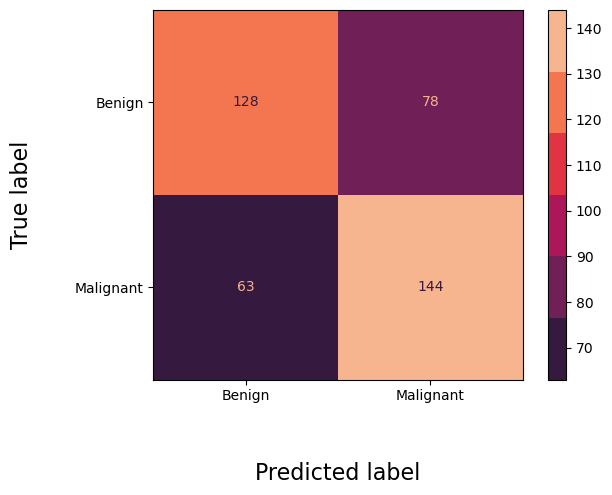

In [73]:
disp = ConfusionMatrixDisplay(confusion_matrix = cm_gray, display_labels = label_names)

palette = sns.color_palette('rocket')

colormap = ListedColormap(palette.as_hex())

disp.plot(cmap = colormap, colorbar = True)

plt.rcParams.update({'font.size': 12})

plt.xlabel('\n\nPredicted label', fontsize=16)
plt.ylabel('True label', fontsize=16, labelpad=30)

### 4.4 Model RGB

> For this model, I'll utilize the binary cross-entropy loss function along with the sigmoid activation function for the last layer. These functions are commonly used for binary classification models..

In [ ]:
# model_rgb_1 = Sequential([
#              Conv2D(filters=32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(image_height, image_width, num_channels_rgb)),
#              MaxPooling2D(pool_size=(2, 2), strides=2),
#              Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'),
#              MaxPooling2D(pool_size=(2, 2), strides=2),
#              Flatten(),
#              Dense(units=2, activation='sigmoid')
# ])

In [ ]:
# model_rgb_1.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=[tf.keras.metrics.Recall()])

In [ ]:
# model_rgb_1.fit(images_rgb_train2, labels_rgb_train2, epochs=2, batch_size=10, validation_data=(images_rgb_val, labels_rgb_val))

In [ ]:
# model_rgb_1.fit(images_rgb_train2, labels_rgb_train2, epochs=2, batch_size=10, validation_data=(images_rgb_val, labels_rgb_val))

In [ ]:
# model_rgb_1.fit(images_rgb_train2, labels_rgb_train2, epochs=2, batch_size=10, validation_data=(images_rgb_val, labels_rgb_val))

In [ ]:
# model_rgb_1.fit(images_rgb_train2, labels_rgb_train2, epochs=2, batch_size=10, validation_data=(images_rgb_val, labels_rgb_val))

##### 4.4.2 Save Model

In [ ]:
# model_rgb_1.save('fbp_model_2.h5')

##### 4.4.3 Open Model

In [79]:
model_rgb = load_model('fbp_model_2.h5')

##### 4.4.4 Evaluate

4.4.4.1 Recall

In [80]:
model_rgb.evaluate(images_rgb_test, labels_rgb_test, verbose=2)

13/13 - 27s - loss: 0.5422 - recall: 0.7409 - 27s/epoch - 2s/step


[0.5422439575195312, 0.7409201264381409]

4.4.4.2 Predictions

In [81]:
probability_model_rgb = tf.keras.Sequential([model_rgb, tf.keras.layers.Softmax()])
predictions_rgb = probability_model_rgb.predict(images_rgb_test)

13/13 [==============================] - 27s 2s/step


In [82]:
predictions_rgb

array([[0.5304021 , 0.46959782],
       [0.52702194, 0.47297806],
       [0.67918384, 0.32081616],
       [0.67017186, 0.3298281 ],
       [0.68287563, 0.3171244 ],
       [0.57157815, 0.42842188],
       [0.70329493, 0.2967051 ],
       [0.7275163 , 0.27248368],
       [0.4613697 , 0.53863025],
       [0.6122213 , 0.3877787 ],
       [0.72486407, 0.27513596],
       [0.7181282 , 0.28187183],
       [0.6959777 , 0.30402228],
       [0.704998  , 0.29500198],
       [0.5641532 , 0.43584678],
       [0.7235054 , 0.27649456],
       [0.7266986 , 0.2733014 ],
       [0.7169145 , 0.28308547],
       [0.68398887, 0.31601113],
       [0.5442722 , 0.45572782],
       [0.7057653 , 0.2942347 ],
       [0.5401941 , 0.45980588],
       [0.6172927 , 0.38270727],
       [0.70313835, 0.2968616 ],
       [0.7141197 , 0.28588036],
       [0.69888824, 0.30111176],
       [0.67688876, 0.32311127],
       [0.66729647, 0.3327035 ],
       [0.6428538 , 0.35714617],
       [0.6929395 , 0.30706048],
       [0.

4.4.4.3 Confusion Matrix

In [83]:
predictions_rgb_rounded = np.argmax(predictions_rgb, axis = -1)
labels_rgb_rounded = np.argmax(labels_rgb_test, axis = -1)

In [84]:
cm_rgb = confusion_matrix(labels_rgb_rounded, predictions_rgb_rounded)
cm_rgb

array([[131,  75],
       [ 33, 174]], dtype=int64)

Text(0, 0.5, 'True label')

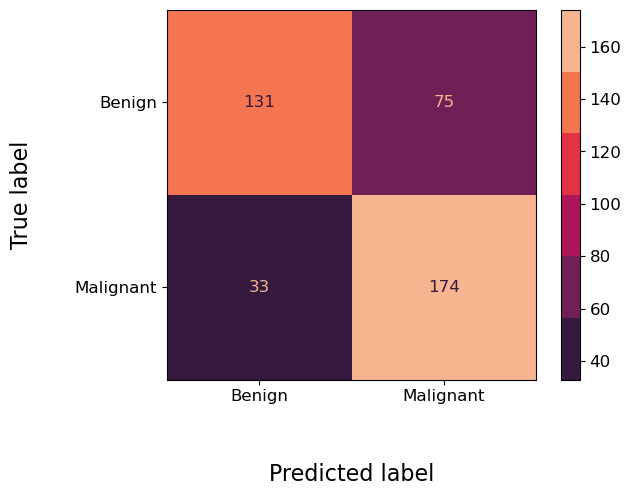

In [85]:
label_names = ['Benign', 'Malignant'] 

disp = ConfusionMatrixDisplay(confusion_matrix = cm_rgb, display_labels = label_names)

disp.plot(cmap = colormap, colorbar = True)

plt.rcParams.update({'font.size': 12})

plt.xlabel('\n\nPredicted label', fontsize=16)
plt.ylabel('True label', fontsize=16, labelpad=30)



### 5 Improving Recall

> Since I aim to improve recall but can't introduce more pictures into the model due to memory limitations, I've devised an alternative approach: for predictions classified as benign by the grayscale model, I'll seek a second opinion from the RGB model.

In [86]:
predictions_rounded_recall = np.array([])

for i in range(0, len(predictions_gray_rounded)):
    if predictions_gray_rounded[i] == 0:
        predictions_rounded_recall = np.append(predictions_rounded_recall, predictions_rgb_rounded[i])
    else:
        predictions_rounded_recall = np.append(predictions_rounded_recall, 1)

In [87]:
cm_recall = confusion_matrix(y_true = labels_rgb_rounded, y_pred = predictions_rounded_recall)

Text(0, 0.5, 'True label')

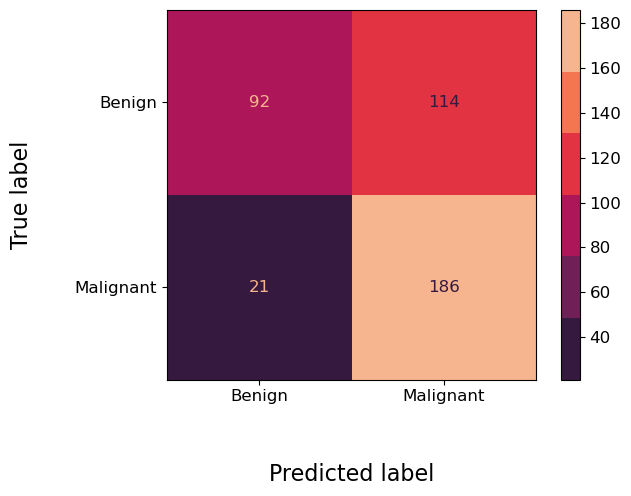

In [88]:
label_names = ['Benign', 'Malignant'] 

disp = ConfusionMatrixDisplay(confusion_matrix = cm_recall, display_labels = label_names)

disp.plot(cmap = colormap, colorbar = True)

plt.rcParams.update({'font.size': 12})

plt.xlabel('\n\nPredicted label', fontsize=16)
plt.ylabel('True label', fontsize=16, labelpad=30)

In [89]:
recall= 186/(21+186)
recall

0.8985507246376812

### 6 Conclusions

> With a recall of almost 90%, this model proves to be a valuable tool that can serve as a second opinion for individuals who have previously been diagnosed with a benign lesion by a doctor.
>
> This model could potentially serve as an alert, prompting individuals to consult their doctor for a second test if the model predicts a malignancy, despite a previous benign diagnosis.
>
> Nonetheless, there is room for improvement, with a precision score of 62%. Additionally, considering the significance of detecting malignant lesions, it's crucial to review the results alongside their probabilities. Always consult a doctor as a priority.

### 7 Test picture function

> I have also created this function to check individual cases.

In [129]:
def test_picture(pict):
    
    width, height = 600, 450
    
    image_gray = Image.open('fbp_pictures_1/'+pict+'.jpg')
    image_gray = image_gray.resize((width, height))
    image_gray = ImageOps.grayscale(image_gray)
    image_gray = np.array(image_gray)
    image_gray = image_gray.reshape(1, 450, 600, 1)
    image_gray = image_gray/255
    predictions_gray = probability_model_gray.predict(image_gray)
    
    image_rgb = Image.open('fbp_pictures_1/'+pict+'.jpg')
    image_rgb = image_rgb.resize((width, height))
    image_rgb = np.array(image_rgb)
    image_rgb = image_rgb.reshape(1, 450, 600, 3)
    image_rgb = image_rgb/255
    predictions_rgb = probability_model_rgb.predict(image_rgb)
    
    if predictions_gray[0][1] >= 0.5:
        print(f'The model predicts the lesion to be malignant with a probability of {round(predictions_gray[0][1] * 100)} %.')
    else:
        if predictions_rgb[0][1] >= 0.5:
            print(f'The model predicts the lesion to be malignant with a probability of {round(predictions_rgb[0][1] * 100)} %.')
        else:
            print(f'The model predicts the lesion to be benign with a probability of {round(predictions_rgb[0][0] * 100)} %.')
    
    return predictions_gray, predictions_rgb

In [130]:
test_picture('ISIC_0025781')

1/1 [==============================] - 0s 94ms/step
The model predicts the lesion to be malignant with a probability of 53 %.


(array([[0.47013238, 0.52986765]], dtype=float32),
 array([[0.31604213, 0.6839579 ]], dtype=float32))